# Problem formulation

**Machine learning problem:** Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.

**What's interesting about it:** Despite both rice and chips sharing shades of yellow, the model's ability to distinguish between the two dishes remains the most intriguing aspect of its definition and training.

# Machine Learning pipeline



---

**Stages in the Pipeline:**

1. **Data Preparation:**
   - **Input:** **MLEnd Yummy Dataset** has raw images of various sizes.
   - **Transformation:** from above observation the resizing of all images to a consistent size was needed to ensures uniformity across images, making them compatible for feature extraction, Hence converted all images into a standard format.
   - **Output:** Processed images ready for feature extraction.

2. **Train/Test Data Split**:
   - **Split Dataset**: I divide the dataset into training and testing subsets.   


3.  **Feature Extraction & Normalization**:
   - **Get Yellow Component**: I extract yellow components to identify chips based on color.
   - **GMLC Feature Extraction**: I extract dissimilarity and correlation features to discern texture variations.
   - **Normalization**: I normalize the extracted features using `StandardScaler`.


4. **Model Training:**
   - **Classifier Training**: I build two pipelines with different classifiers (LinearSVC, RandomForestClassifier) to train models based on the extracted features.
   - **Prediction Comparison**: I make predictions using the trained models on the train data and compare their results to determine performance.

5. **Evaluate Model Performance**:
   - **Accuracy**: I compare results between RandomForestClassifier and LinearSVC models, plotting confusion matrices to identify the superior model.

In [2]:
pip install mlend


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 4.6 MB/s eta 0:00:00


In [3]:
import mlend
from mlend import download_yummy_small, yummy_small_load

baseDir = download_yummy_small(save_to = '../MLEnd')

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|99\99|00099.jpg
Done!


**Data Preparation:**

   - Obtain the MLEnd Yummy Dataset , where dataset is labeled and containing images of dishes with rice or chips.
   - Split the dataset into training and testing sets.

**Create train and test Datasets**

 We will use the **yummy_small_load function** included in our **mlend** library for this, and will specify which dataset each sample should belong to, by using the column **'Benchmark_A'** in the CSV file:

In [4]:
TrainSet, TestSet, Map = yummy_small_load(datadir_main=baseDir,train_test_split='Benchmark_A')

Total 99 found in ../MLEnd/yummy/MLEndYD_images_small/


In [5]:
TrainSet.keys()
TrainSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

In [6]:
Map

{'Rice_Chips': {'chips': 0, 'rice': 1}}

In [7]:
TrainSet['Y']

array(['chips', 'chips', 'rice', 'rice', 'rice', 'chips', 'rice', 'chips',
       'rice', 'chips', 'chips', 'rice', 'chips', 'rice', 'rice', 'chips',
       'rice', 'rice', 'chips', 'rice', 'chips', 'rice', 'rice', 'chips',
       'chips', 'chips', 'rice', 'rice', 'chips', 'rice', 'rice', 'rice',
       'rice', 'rice', 'chips', 'chips', 'chips', 'rice', 'chips', 'rice',
       'rice', 'chips', 'chips', 'rice', 'chips', 'chips', 'chips',
       'chips', 'chips', 'chips', 'chips', 'rice', 'chips', 'rice',
       'chips', 'chips', 'rice', 'rice', 'chips', 'chips', 'rice', 'rice',
       'rice', 'rice', 'rice', 'chips', 'rice', 'chips', 'rice', 'chips'],
      dtype=object)

In [8]:
TrainSet['Y_encoded']

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0])

In [9]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Y_encoded']
Y_test  = TestSet['Y_encoded']

**Resizing Images**

Our first step will be to resize all the images to so that they have the same size.To keep the aspect ratio of image as it is, we will append black color to make so that images are squared and then we will resize them to 200x200 pixels.



In [10]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])


In [11]:
pip install spkit

Loading images from **X_train_paths** and **X_test_paths**, ensuring uniformity by resizing them to 200x200 pixels through functions like **make_it_square** and **resize_img**. It converts the processed images into NumPy arrays and inspects their shapes to ensure uniformity across the training and testing sets.

In [12]:
import spkit as sp
import matplotlib.pyplot as plt
import numpy as np

X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)

X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|70\70|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|29\29|
Done!


((70, 200, 200, 3), (29, 200, 200, 3))

# Transformation stage

**Feature Extraction:**

I created the **FeatureExtractor** class, a custom transformer in scikit-learn. It combines **yellow pixel count** and **GMLC feature** extraction techniques, processing images using HSV thresholds and grayscale properties, respectively.
These functions aim to derive **three** specific image features, **enabling a transformation of the predictor space to a lower-dimensional one**, addressing the challenge posed by the high-dimensional nature of the original image data.

In [13]:
import skimage as ski
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops
from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)

  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

In [14]:
#Let us now extract the three features from each image and create the transform sets `X_train_f` and `X_test_f`:
X_train_f = []
for k, I in enumerate(X_train):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_train_f.append([f1,f2,f3])

X_test_f = []
for k, I in enumerate(X_test):
  f1 = get_yellow_component(I)
  f2,f3 = GMLC_features(I)
  X_test_f.append([f1,f2,f3])

In [15]:
#After formatting both `X_train_f` and `X_test_f` as numpy arrays, we can check their respective shapes:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((70, 3), (29, 3))

# Modelling



**Note :**

 **X_train_f** represents a collection of **70 samples described by 3 attributes** and **X_test_f** represent a collection of **29 samples described by 3 attributes**. This feature extraction stage has reduced the dimensionality of our problem from 120,000D to 3D.

**Normalisation:** In addition to reducing the dimensionality of the prediction space, let's implement a normalisation stage to ensure that the 3 attributes in the new prediction space take on a similar range of values. We will implement standardisation.

In [16]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

#Normalised value
X_train_fn = (X_train_f - MEAN)/SD
X_test_fn = (X_test_f - MEAN)/SD


#Normalisation byStandardScaler

from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data to calculate mean and standard deviation
scaler.fit(X_train_f)

# Transform training and testing data using the fitted scaler
X_train_fn_S= scaler.transform(X_train_f)
X_test_fn_S = scaler.transform(X_test_f)



**ML model that I want to build** is **Support Vector Classifier (SVC)** because of its ability to handle complex decision boundaries, robustness to overfitting, effectiveness in high-dimensional spaces, specially when dealing with moderately sized datasets and nonlinear relationships between features.


**Random Forest Classifier** is an excellent alternative to SVC , It provides a feature importance measure, which helps identify the most influential features in the dataset. This insight is valuable for feature selection and understanding the dataset's characteristics.
```





In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

modelSVC = LinearSVC(C=1)
modelRFC= RandomForestClassifier(n_estimators=5,max_depth=3,random_state=50)

print(modelSVC.fit(X_train_fn, Y_train))


print(modelRFC.fit(X_train_fn_S, Y_train))

LinearSVC(C=1)
RandomForestClassifier(max_depth=3, n_estimators=5, random_state=50)


# Methodology



Now, let's use this trained model to predict the labels in the training and test datasets and based on the predicted labels, let's calculate the **training and test accuracy** and **Confusion Matrix**

In [18]:
ytpSVC = modelSVC.predict(X_train_fn)
yspSVC = modelSVC.predict(X_test_fn)

train_accuracySVC = np.mean(ytpSVC==Y_train)
test_accuracySVC = np.mean(yspSVC==Y_test)

print('Training AccuracySVC:\t',train_accuracySVC)
print('Test  AccuracySVC:\t',test_accuracySVC)



Training AccuracySVC:	 0.6285714285714286
Test  AccuracySVC:	 0.5862068965517241


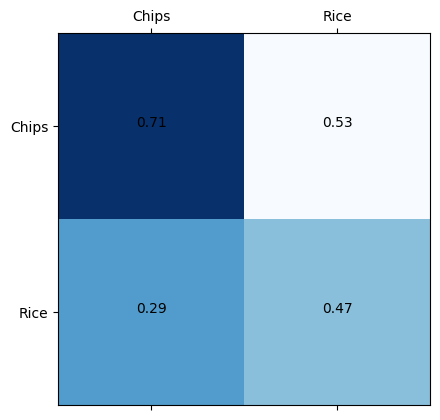

In [19]:
Ac = np.mean(yspSVC[Y_test.astype(int)==0]==0)
Ar = np.mean(yspSVC[Y_test.astype(int)==1]==1)

Mc = np.mean(yspSVC[Y_test.astype(int)==0]==1)
Mr = np.mean(yspSVC[Y_test.astype(int)==1]==0)

Confusion_Matrix_SVC = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(Confusion_Matrix_SVC)




# Dataset


**Visualising dishes**

In this section, we will visualise the images that we have extracted from the MLEnd Small Yummy Dataset. Specifically, we will select five dishes that contain rice and five dishes that have chips?

Rice


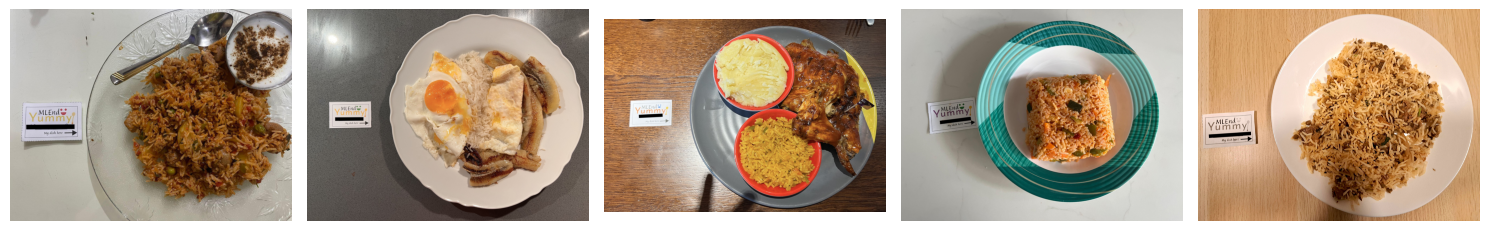

Chips


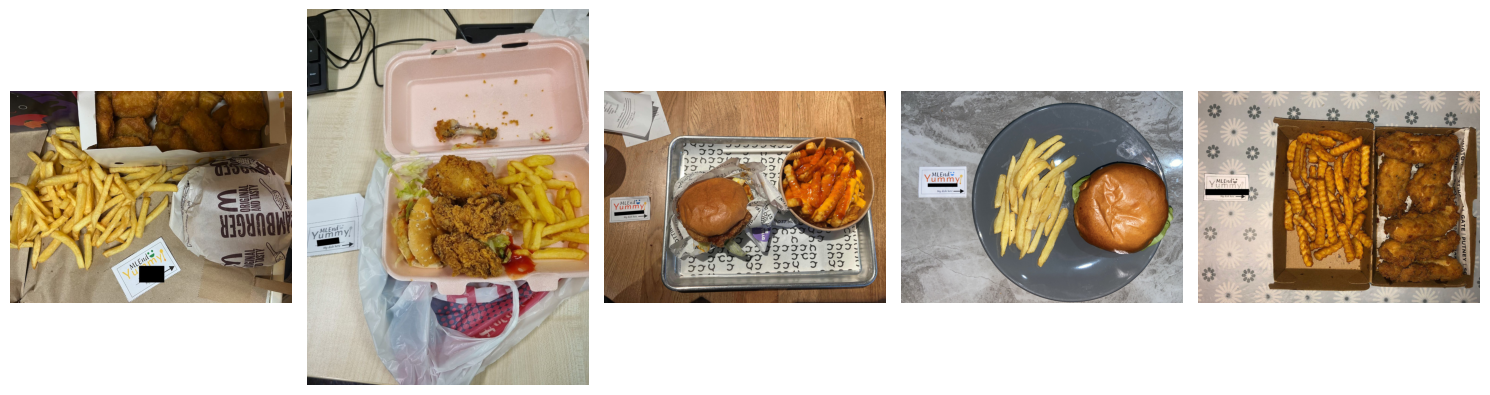

In [20]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

# Results

**Random Forest** might be chosen over SVC for its capability to handle complex, nonlinear data patterns effectively, robustness to noisy datasets, and inherent insights into feature importance, making it a practical choice for **experiments** where these factors are crucial.

In [21]:
#let's use this trained Random Forest model to predict the labels in the training and test datasets and based on the predicted labels.

ytpRFC = modelRFC.predict(X_train_fn)
yspRFC = modelRFC.predict(X_test_fn)

train_accuracyRFC = np.mean(ytpRFC==Y_train)
test_accuracyRFC  = np.mean(yspRFC==Y_test)

print('Training AccuracyRFC:\t',train_accuracyRFC)
print('Test  AccuracyRFC:\t',test_accuracyRFC)

Training AccuracyRFC:	 0.8
Test  AccuracyRFC:	 0.6206896551724138


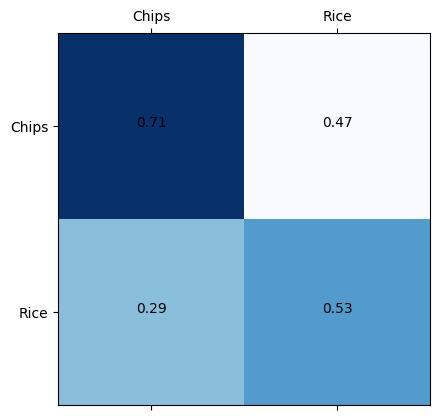

In [22]:
# Confusion Matrix for Random Forest

Ac = np.mean(yspRFC[Y_test.astype(int)==0]==0)
Ar = np.mean(yspRFC[Y_test.astype(int)==1]==1)

Mc = np.mean(yspRFC[Y_test.astype(int)==0]==1)
Mr = np.mean(yspRFC[Y_test.astype(int)==1]==0)

Confusion_Matrix_RFC = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(Confusion_Matrix_RFC)

**Results**

**Support Vector Classifier**
Training AccuracySVC:	 0.62
Test  AccuracySVC:	 0.58
  

**Random Forest Classifier**
Training AccuracyRFC:	 0.8
Test  AccuracyRFC:	 0.62

SVC achieved a training accuracy of 62.86% and a test accuracy of 58.62%. While,
:RFC performed better with a training accuracy of 80.00% and a test accuracy of 62.07%.
    



# Let's print the **classification report**

In [27]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, yspRFC))
# for Random Forest Classifier.

              precision    recall  f1-score   support

           0       0.59      0.71      0.65        14
           1       0.67      0.53      0.59        15

    accuracy                           0.62        29
   macro avg       0.63      0.62      0.62        29
weighted avg       0.63      0.62      0.62        29



In [25]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, yspSVC))
# for Support Vector Classifier.

              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.64      0.47      0.54        15

    accuracy                           0.59        29
   macro avg       0.60      0.59      0.58        29
weighted avg       0.60      0.59      0.58        29



Both models exhibit moderate performance, with the SVC achieving 59% accuracy, better precision for class 1 (64%) than class 0 (56%), and higher recall for class 0 (71%) over class 1 (47%). The RFC model shows 62% accuracy, demonstrating superior precision for class 1 (67%) versus class 0 (59%) and slightly higher recall for class 0 (71%) compared to class 1 (53%).

**Both models reveal room for improvement in achieving balanced precision and recall across both classes to enhance overall performance.**

# Conclusions

The observation from the accuracy scores indicates that the **Random Forest Classifier (RFC) outperforms the Support Vector Classifier (SVC) in both training and test accuracies**.

From above **confusion matrix** for SVC and RFC. **The model tends to predict chips more accurately than rice, signaling potential bias in the dataset towards chips.**





The conclusion drawn from these results suggests that, based on this specific dataset, the Random Forest model performs better in terms of accuracy compared to the Support Vector model for this classification task and performs better for chips as compare to rice.